## Struture de données

In [1]:

import conf_mgt
from utils import yamlread


In [3]:
conf = conf_mgt.conf_base.Default_Conf()
conf.update(yamlread('confs/my_conf-2.yml'))

In [5]:
dset = 'eval'
eval_name = conf.get_default_eval_name()

dl = conf.get_dataloader(dset=dset, dsName=eval_name)

### Le dataset est obtenu dans la méthode get_dataloader (fichier conf_base.py) via les métadonnées du fichier de configuration visibles ci-dessous.

In [6]:
dataconfig = conf['data']['eval'][conf.get_default_eval_name()]
dataconfig

{'mask_loader': True,
 'gt_path': './data/datasets/gts/face',
 'mask_path': './data/datasets/gt_keep_masks/face',
 'image_size': 256,
 'class_cond': False,
 'deterministic': True,
 'random_crop': False,
 'random_flip': False,
 'return_dict': True,
 'drop_last': False,
 'batch_size': 1,
 'return_dataloader': True,
 'offset': 0,
 'max_len': 8,
 'paths': {'srs': './log/face_example/inpainted',
  'lrs': './log/face_example/gt_masked',
  'gts': './log/face_example/gt',
  'gt_keep_masks': './log/face_example/gt_keep_mask'}}

### La configuration du dataset contient notamment les arguments utilisés par la classe ImageDatasetInpa (image_dataset.py dans le dossier guided_diffusion) pour retourner à partir du répertoire des images un dataset pytorch. Ce dataset est converti en dataloader avec la fonction DataLoader dans le même fichier.

### Pour créer un dataset ImageDatasetInpa il faut la liste des imagages que l'on souhaite utiliser, et que l'on récupère avec la fonction _list_image_files_recursivcely.

### Ci-dessous figure la fonction _list_image_recursively telle qu'elle est dans le fichier image_dataset.py et on montre comment elle permet de récupérer les répertoires des images et des masques.

In [ ]:
import blobfile as bf

def _list_image_files_recursively(data_dir):
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(_list_image_files_recursively(full_path))
    return results

In [25]:
gtpath = dataconfig['gt_path']
_list_image_files_recursively(gtpath)

['./data/datasets/gts/face\\000000.png',
 './data/datasets/gts/face\\000001.png',
 './data/datasets/gts/face\\000002.png',
 './data/datasets/gts/face\\000003.png',
 './data/datasets/gts/face\\000004.png',
 './data/datasets/gts/face\\000005.png',
 './data/datasets/gts/face\\000006.png',
 './data/datasets/gts/face\\000007.png']

In [26]:
maskpath = dataconfig['mask_path']
_list_image_files_recursively(maskpath)

['./data/datasets/gt_keep_masks/face\\000000.png',
 './data/datasets/gt_keep_masks/face\\000001.png',
 './data/datasets/gt_keep_masks/face\\000002.png',
 './data/datasets/gt_keep_masks/face\\000003.png',
 './data/datasets/gt_keep_masks/face\\000004.png',
 './data/datasets/gt_keep_masks/face\\000005.png',
 './data/datasets/gt_keep_masks/face\\000006.png',
 './data/datasets/gt_keep_masks/face\\000007.png']

### Dans la méthode get_datalaoder ces listes de répertoires sont récupérées. Ensuite ils sont données pour créer une instance de la classe ImageDatasetInpa (classe de type Pytorch dataset). Dans le code de cette classe on voit (lignes 160, 163) que les images et les masques sont associés par l'ordre de la liste triée des répertoires associés aux masques et aux images. L'élément i de la liste des images triées est associé à l'élément i de la liste des masques triés (sorted). Ci-dessous on récupère la liste des paires image/masque associés dans notre exemple. (De cette façon, donner le même nom aux fichiers est suffisant pour qu'ils soient correctement appairés).


In [33]:
np.transpose([sorted(_list_image_files_recursively(maskpath)),sorted(_list_image_files_recursively(gtpath))])

array([['./data/datasets/gt_keep_masks/face\\000000.png',
        './data/datasets/gts/face\\000000.png'],
       ['./data/datasets/gt_keep_masks/face\\000001.png',
        './data/datasets/gts/face\\000001.png'],
       ['./data/datasets/gt_keep_masks/face\\000002.png',
        './data/datasets/gts/face\\000002.png'],
       ['./data/datasets/gt_keep_masks/face\\000003.png',
        './data/datasets/gts/face\\000003.png'],
       ['./data/datasets/gt_keep_masks/face\\000004.png',
        './data/datasets/gts/face\\000004.png'],
       ['./data/datasets/gt_keep_masks/face\\000005.png',
        './data/datasets/gts/face\\000005.png'],
       ['./data/datasets/gt_keep_masks/face\\000006.png',
        './data/datasets/gts/face\\000006.png'],
       ['./data/datasets/gt_keep_masks/face\\000007.png',
        './data/datasets/gts/face\\000007.png']], dtype='<U45')

### La configuration json contient aussi une clé "paths" qui contient les répertoires de sauvegarde des données après passage dans le modèle. Ces répertoires ne sont pas utilisés explicitement dans les fichiers, c'est à nous de les récupérer au besoin pour sauvegarder les images manuellement.

### Enfin, l'argument image_size est très important puisqu'il détermine le format des données du DataLoader récupéré, via la fonction center_crop_arr() de image_dataset.py. Pour mettre les images à la taille souhaitée on peut utiliser un cropping des images via 'andom_crop' dans la configuration. Toutefois celui-ci n'est pas implémenté. En evaluation on préfère tout simplement redimensionner l'image via cette fonction qui est utilisée dans le code de la classe ImageDatasetInpa. Celle-ci redimensionne simplement l'image et le masque à la bonne taille.

### Pour récupérer ces images on doit les renormaliser entre 0 et 255. En effet le modèle traite les images entre -1 et 1 sans normalisation de moyenne/déviation.

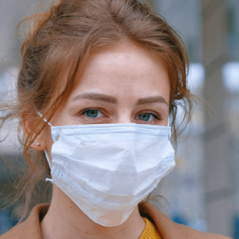

In [13]:
IMAGE_SIZE = 239
def toU8(sample):
    if sample is None:
        return sample

    sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    sample = sample.detach().cpu().numpy()
    return sample


from torchvision import transforms as T
import torch as th
dataconfig = {'mask_loader': True,
 'gt_path': './data/datasets/gts/face',
 'mask_path': './data/datasets/gt_keep_masks/face',
 'image_size': IMAGE_SIZE,
 'class_cond': False,
 'deterministic': True,
 'random_crop': False,
 'random_flip': False,
 'return_dict': True,
 'drop_last': False,
 'batch_size': 1,
 'return_dataloader': True,
 'offset': 0,
 'max_len': 8,
 'paths': {'srs': './log/face_example/inpainted',
  'lrs': './log/face_example/gt_masked',
  'gts': './log/face_example/gt',
  'gt_keep_masks': './log/face_example/gt_keep_mask'}
             }

conf['data']['eval'][eval_name] = dataconfig
dl = conf.get_dataloader(dset=dset, dsName=eval_name)
batch = next(iter(dl))
T.ToPILImage()(toU8(batch['GT'])[0])